<a href="https://colab.research.google.com/github/dmburns1729/Class-Files/blob/main/Copy_of_Core_1_Neural_Network_Kaggle_Exercise_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

#Core Assignment 1 - Kaggle Neural Network

- Name: Tyler Schelling
- Date: 11/29/2022

##Task

Now, put neural networks into action. You are tasked with building a neural network using data from this [kaggle competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=sample_submission.csv). To complete the assignment, you will train and evaluate your model using only the train.csv. Remember, with Kaggle competitions, the test.csv does not include values for the target! The test.csv is only used for the competition, and you cannot evaluate your model using the test.csv without submitting your predictions to Kaggle.

Required Task:
1. Be sure to perform a train test split on the train.csv so you can evaluate your models.
2. Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance. Be sure to include some form of regularization with at least one model.
3. Select your best model!

Optional (but fun!)
- Use your best model to make predictions using the features in test.csv.
- Submit to the Kaggle competition to see how your did!
- Include a screenshot of your results from the Kaggle competition inserted in a markdown cell at the bottom of your notebook.

##Assignment

###Mount Drive | Import Libraries | Download Data

*   List item
*   List item



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

In [ ]:
df = pd.read_csv('/content/train (1).csv', index_col = 'Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
#Evaluate size of the dataframe
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset contains 1460 rows and 80 columns.


###Functions

In [ ]:
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

###Correlation for Feature Selection

In [ ]:
#Create a features dataframe to encode categorical data for correlation
feat_df = df.copy()
objList = feat_df.select_dtypes(include = "object").columns
feat_df[objList] = feat_df[objList].apply(LabelEncoder().fit_transform)

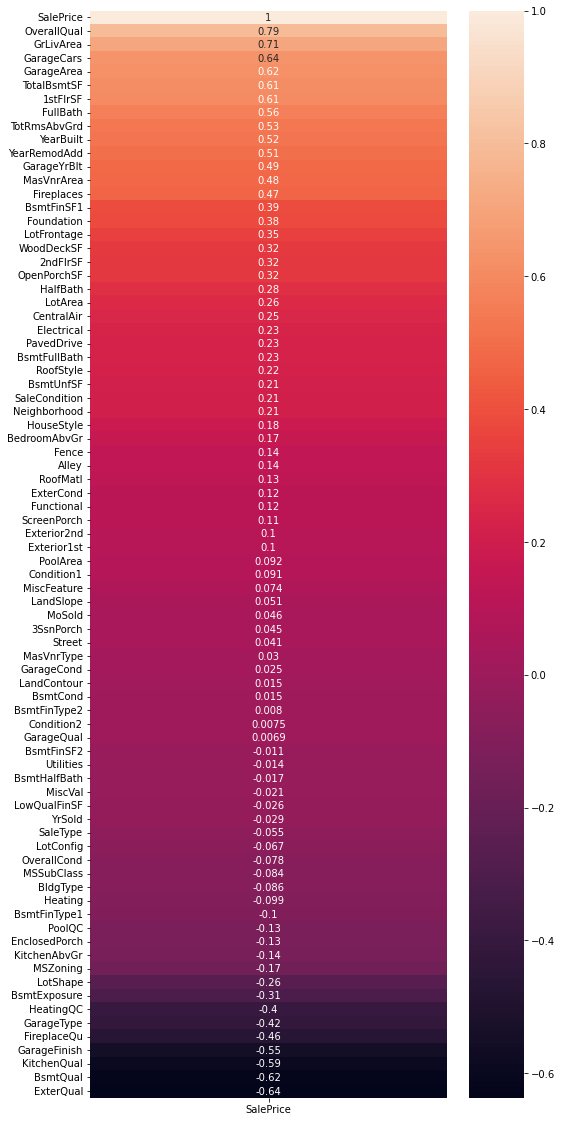

In [ ]:
#Sort the correlations of each column to SalePrice
corr = feat_df.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False)
plt.figure(figsize= (8,20))
sns.heatmap(corr, annot = True);

###Feature Selection

In [ ]:
#Select features with a greater or lesser correlation than 0.25 to SalePrice
train_df = df.copy()
train_df.drop(columns = corr[(corr['SalePrice'] < 0.25) & (corr['SalePrice'] > -0.25)].index, inplace = True)

In [ ]:
#Create a features dataframe to encode categorical data for correlation
feat2_df = train_df.copy()
objList = feat2_df.select_dtypes(include = "object").columns
feat2_df[objList] = feat2_df[objList].apply(LabelEncoder().fit_transform)

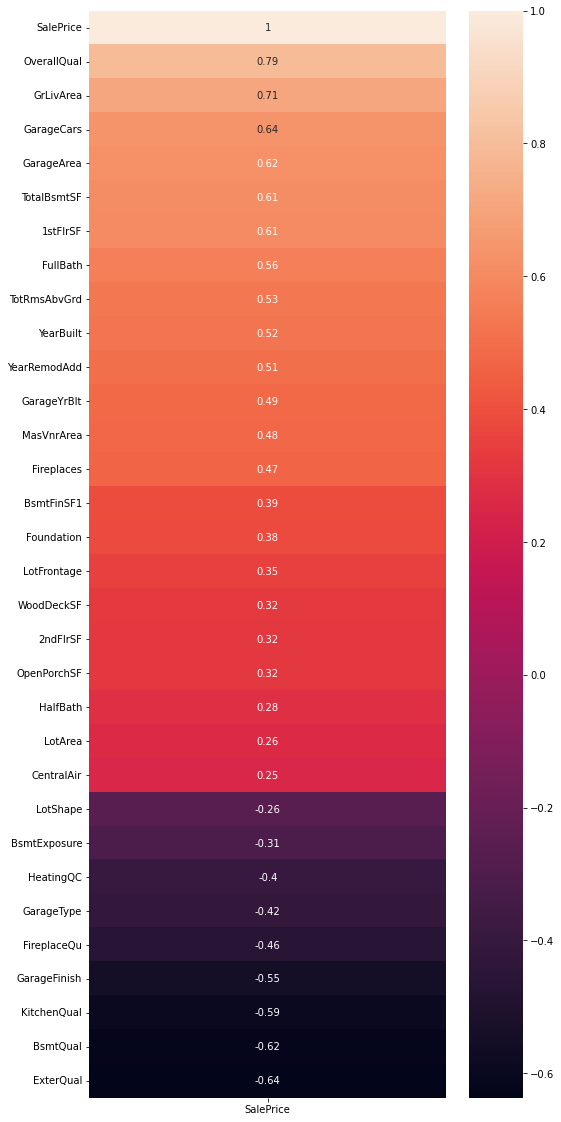

In [ ]:
#Sort the correlations of each column to SalePrice
corr2 = feat2_df.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False)
plt.figure(figsize= (8,20))
sns.heatmap(corr2, annot = True);

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   LotArea       1460 non-null   int64  
 2   LotShape      1460 non-null   object 
 3   OverallQual   1460 non-null   int64  
 4   YearBuilt     1460 non-null   int64  
 5   YearRemodAdd  1460 non-null   int64  
 6   MasVnrArea    1452 non-null   float64
 7   ExterQual     1460 non-null   object 
 8   Foundation    1460 non-null   object 
 9   BsmtQual      1423 non-null   object 
 10  BsmtExposure  1422 non-null   object 
 11  BsmtFinSF1    1460 non-null   int64  
 12  TotalBsmtSF   1460 non-null   int64  
 13  HeatingQC     1460 non-null   object 
 14  CentralAir    1460 non-null   object 
 15  1stFlrSF      1460 non-null   int64  
 16  2ndFlrSF      1460 non-null   int64  
 17  GrLivArea     1460 non-null   int64  
 18  FullBath      1460 non-null 

In [ ]:
#Evaluate size of the dataframe
print(f'The dataset contains {train_df.shape[0]} rows and {train_df.shape[1]} columns.')

The dataset contains 1460 rows and 32 columns.


###Data Cleaning

In [ ]:
#check duplicates
train_df.duplicated().sum()

0

In [ ]:
train_df.isna().sum()

LotFrontage     259
LotArea           0
LotShape          0
OverallQual       0
YearBuilt         0
YearRemodAdd      0
MasVnrArea        8
ExterQual         0
Foundation        0
BsmtQual         37
BsmtExposure     38
BsmtFinSF1        0
TotalBsmtSF       0
HeatingQC         0
CentralAir        0
1stFlrSF          0
2ndFlrSF          0
GrLivArea         0
FullBath          0
HalfBath          0
KitchenQual       0
TotRmsAbvGrd      0
Fireplaces        0
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageCars        0
GarageArea        0
WoodDeckSF        0
OpenPorchSF       0
SalePrice         0
dtype: int64

In [ ]:
#train_df['LotFrontage'].fillna(0, inplace = True)
train_df['MasVnrArea'].fillna(0, inplace = True)
train_df['BsmtQual'].fillna('None', inplace = True)
train_df['BsmtExposure'].fillna('None', inplace = True)
train_df['FireplaceQu'].fillna('None', inplace = True)
train_df['GarageType'].fillna('None', inplace = True)
train_df['GarageYrBlt'].fillna(0, inplace = True)
train_df['GarageFinish'].fillna('None', inplace = True)

In [ ]:
# Dave added frontage filler.  Will cause leakage

In [ ]:
# Loop through index values of the dataframe
# Will need to fill with this formula AFTER test, train split

def fill_LotFrontage(data_frame, fill_data):

  for ind in data_frame.index:

    x = data_frame.loc[ind, 'LotFrontage']

    if np.isnan(x) == True:

      # Impute LotFrontage based on average of sqauare root of Lot Area and 1stFlrSF estimators

      ratio_area_est = data_frame['LotFrontage'] / (data_frame['LotArea']) ** (1/2)
      area_est = ratio_area_est.mean() * data_frame.loc[ind, 'LotArea'] ** (1/2)
#      print(area_est)

      ratio_first_est = data_frame['LotFrontage'] / (data_frame['1stFlrSF']) ** (1/2)
      first_est = ratio_first_est.mean() * data_frame.loc[ind, '1stFlrSF'] ** (1/2)
#      print(first_est)

      frontage_est = round((area_est + first_est) / 2,0)
      frontage_est = int(frontage_est)
#      print(frontage_est)

      data_frame.loc[ind, 'LotFrontage'] = int(frontage_est)

      data_frame.loc[ind, 'LotFrontage'] = int(data_frame.loc[ind, 'LotFrontage'])

#      print(data_frame.loc[ind, 'LotFrontage'])
#      print("\n")

In [ ]:
fill_LotFrontage(train_df, train_df)

In [ ]:
train_df.isna().sum()

LotFrontage     0
LotArea         0
LotShape        0
OverallQual     0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
ExterQual       0
Foundation      0
BsmtQual        0
BsmtExposure    0
BsmtFinSF1      0
TotalBsmtSF     0
HeatingQC       0
CentralAir      0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
FullBath        0
HalfBath        0
KitchenQual     0
TotRmsAbvGrd    0
Fireplaces      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageCars      0
GarageArea      0
WoodDeckSF      0
OpenPorchSF     0
SalePrice       0
dtype: int64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1460 non-null   float64
 1   LotArea       1460 non-null   int64  
 2   LotShape      1460 non-null   object 
 3   OverallQual   1460 non-null   int64  
 4   YearBuilt     1460 non-null   int64  
 5   YearRemodAdd  1460 non-null   int64  
 6   MasVnrArea    1460 non-null   float64
 7   ExterQual     1460 non-null   object 
 8   Foundation    1460 non-null   object 
 9   BsmtQual      1460 non-null   object 
 10  BsmtExposure  1460 non-null   object 
 11  BsmtFinSF1    1460 non-null   int64  
 12  TotalBsmtSF   1460 non-null   int64  
 13  HeatingQC     1460 non-null   object 
 14  CentralAir    1460 non-null   object 
 15  1stFlrSF      1460 non-null   int64  
 16  2ndFlrSF      1460 non-null   int64  
 17  GrLivArea     1460 non-null   int64  
 18  FullBath      1460 non-null 

###Validation Split

In [ ]:
X = train_df.drop(columns = 'SalePrice')
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.1)

In [ ]:
# Preprocessing
cat_selector = make_column_selector(dtype_include = 'object')
ohe = OneHotEncoder(handle_unknown='ignore')

num_selector = make_column_selector(dtype_include = 'number')
scaler = StandardScaler()

preprocessor = make_column_transformer((ohe, cat_selector), (scaler, num_selector), remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f51eb5f1d60>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f51ebe06640>)])

###Preprocess the Data

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

###Define the Network Structure (Function)

In [ ]:
def model_builder(hidden, nodes):
    model = keras.Sequential()

    #Add input layer and 1 hidden layer
    model.add(Dense(nodes, input_dim=X_train.shape[1], activation = 'relu'))
    #Add additional hidden layers
    for i in range(hidden):
        model.add(Dense(nodes, activation = 'relu'))
    # Add output layer with 1 node
    model.add(Dense(1, activation = 'linear'))

    model.compile(loss = 'mse', optimizer='adam',
                metrics=['mae', 'mse'])

    return model

In [ ]:
## define the evaluate_regression function here.

def evaluate_regression(model, X_test, y_test, label="Test Data"):
  y_pred = model.predict(X_test)


   ## Print regression report for the test data
  print('---'*20)
  print(f"REGRESSION REPORT FOR: {label}")
  print('---'*20)
  # print the classiffication report from the test data

  print(f'final RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)),-1)}')
  print(f'final MAE: {round(mean_absolute_error(y_test, y_pred),-1)}')
  print(f'final R2: {round(r2_score(y_test, y_pred),4)}')

  plt.show()

###Early Stopping

In [ ]:
early_stopping_cb = EarlyStopping(monitor='mse', patience=20, mode='min', restore_best_weights=False)

###Model 1

In [ ]:
model1 = model_builder(2, 10)
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 10)                730       
                                                                 
 dense_27 (Dense)            (None, 10)                110       
                                                                 
 dense_28 (Dense)            (None, 10)                110       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit your model
history1 = model1.fit(X_train, y_train,
                                validation_data = (X_test, y_test),
                                epochs = 250,
                                verbose = 0,
                                callbacks = [early_stopping_cb])

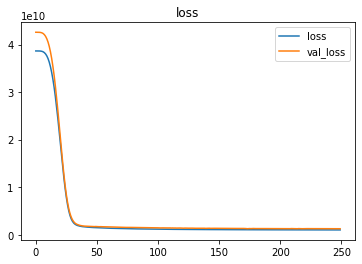

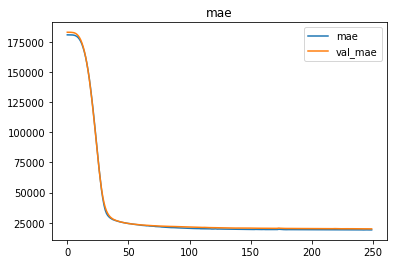

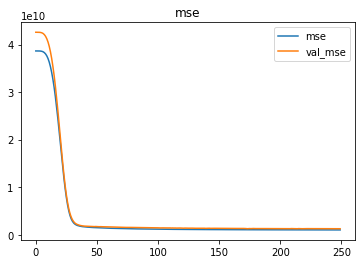

In [ ]:
plot_history(history1)

In [ ]:
evaluate_regression(model1, X_test, y_test, label="Test Data")

5/5 [==============================] - 0s 2ms/step
------------------------------------------------------------
REGRESSION REPORT FOR: Test Data
------------------------------------------------------------
final RMSE: 35730.0
final MAE: 19980.0
final R2: 0.8602


In [ ]:
loss, mae, mse= model1.evaluate(X_test, y_test)

print("Test Mean absolute error: {:5.2f}".format(mae))

5/5 [==============================] - 0s 3ms/step - loss: 1276932352.0000 - mae: 19984.0410 - mse: 1276932352.0000
Test Mean absolute error: 19984.04


###Model 2

In [ ]:
model2 = model_builder(3, 25)
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 25)                1825      
                                                                 
 dense_17 (Dense)            (None, 25)                650       
                                                                 
 dense_18 (Dense)            (None, 25)                650       
                                                                 
 dense_19 (Dense)            (None, 25)                650       
                                                                 
 dense_20 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3,801
Trainable params: 3,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit your model
history2 = model2.fit(X_train, y_train,
                                validation_data = (X_test, y_test),
                                epochs = 250,
                                verbose = 0,
                                callbacks = [early_stopping_cb])

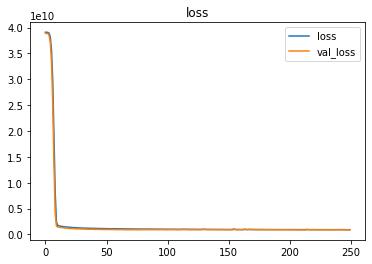

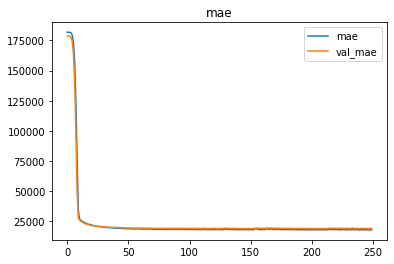

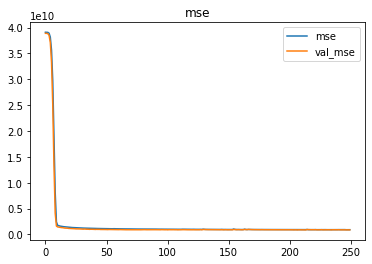

In [ ]:
plot_history(history2)

In [ ]:
evaluate_regression(model2, X_test, y_test, label="Test Data")

5/5 [==============================] - 0s 5ms/step
------------------------------------------------------------
REGRESSION REPORT FOR: Test Data
------------------------------------------------------------
final RMSE: 32000.0
final MAE: 18340.0
final R2: 0.8879


###Model 3

In [ ]:
model3 = model_builder(3, 50)
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 50)                3650      
                                                                 
 dense_22 (Dense)            (None, 50)                2550      
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 50)                2550      
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,351
Trainable params: 11,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit your model
history3 = model3.fit(X_train, y_train,
                                validation_data = (X_test, y_test),
                                epochs = 250,
                                verbose = 0,
                                callbacks = [early_stopping_cb])

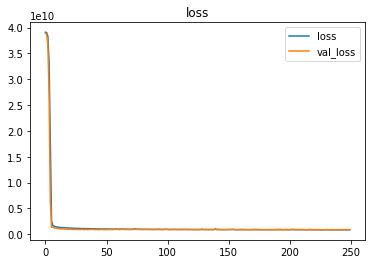

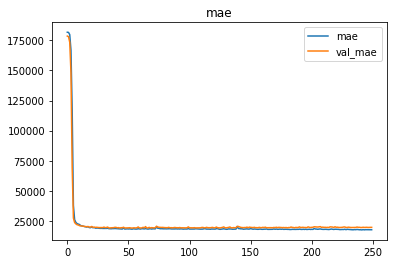

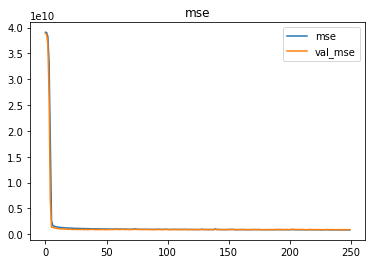

In [ ]:
plot_history(history3)

In [ ]:
evaluate_regression(model3, X_test, y_test, label="Test Data")

5/5 [==============================] - 0s 7ms/step
------------------------------------------------------------
REGRESSION REPORT FOR: Test Data
------------------------------------------------------------
final RMSE: 31980.0
final MAE: 18990.0
final R2: 0.8881


###Final Prediction (Model 2)

In [ ]:
test_df = pd.read_csv('/content/test (1).csv', index_col = 'Id')
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
test_df.drop(columns = corr[(corr['SalePrice'] < 0.25) & (corr['SalePrice'] > -0.25)].index, inplace = True)

In [ ]:
for col in test_df.select_dtypes(include='object').columns:
    test_df[col].fillna('None', inplace = True)

In [ ]:
for col in test_df.select_dtypes(include='number').columns:
    test_df[col].fillna(0, inplace = True)

In [ ]:
test_df = preprocessor.transform(test_df)

In [ ]:
test_pred = model2.predict(test_df).flatten()
test_pred

46/46 [==============================] - 0s 2ms/step


array([113446.27 , 158784.27 , 175245.4  , ..., 163495.39 , 111123.195,
       253577.8  ], dtype=float32)

In [ ]:
id_col = pd.read_csv('/content/test (1).csv')

In [ ]:
submission = pd.DataFrame({'Id': id_col['Id'], 'SalePrice': test_pred})
submission.head()

,Id,SalePrice
0,1461,113446.273438
1,1462,158784.265625
2,1463,175245.406250
3,1464,195261.453125
4,1465,201270.937500


In [ ]:
submission.to_csv('/content/drive/MyDrive/02. Life/Coding Dojo/submission_neural_network_model2.csv', index = False)

FileNotFoundError: ignored

###Kaggle Submission

Public Score: 0.15048

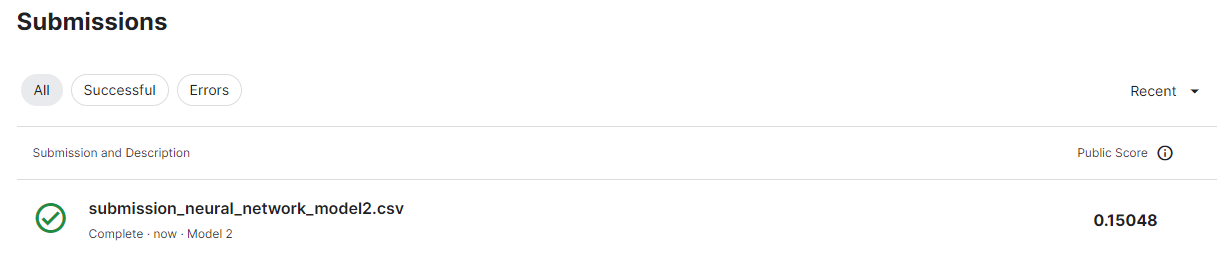

---

###Messing around with hyperparameter tuning (ignore)

In [ ]:
def model_builder(hp):
    model = keras.Sequential()

    model.add(Dense(36, input_dim=X_train.shape[1], activation = 'relu'))
    model.add(Dense(72, activation = 'relu'))
    model.add(Dense(144, activation = 'relu'))
    model.add(Dense(288, activation = 'relu'))
    model.add(Dense(36, activation = 'relu'))

    # Add output layer with 1 node
    model.add(Dense(1, activation = 'linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(loss = 'mse', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                metrics=['mae', 'mse'])

    return model

In [ ]:
tuner = kt.Hyperband(model_builder, objective = 'val_mse', max_epochs = 250, executions_per_trial = 2, directory = 'hyperband', project_name = 'houseprices', overwrite = True)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)

In [ ]:
tuner.search(x = X_train, y = y_train, epochs = 250, batch_size = 64, validation_data = (X_test, y_test), verbose = 0, callbacks = [early_stopping_cb])

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
best_model = tuner.get_best_models(num_models = 1)[0]

In [ ]:
tuned_model = tuner.hypermodel.build(best_hps)

In [ ]:
# Fit your model
history = tuned_model.fit(X_train, y_train,
                                validation_data = (X_test, y_test),
                                epochs = 250,
                                verbose = 0,
                                callbacks = [early_stopping_cb])

In [ ]:
loss, mae, mse= tuned_model.evaluate(X_test, y_test, verbose=2)

print("Test Mean absolute error: {:5.2f}".format(mae))

In [ ]:
plot_history(history)

####Tuned Predictions

In [ ]:
test_df = pd.read_csv('/content/test (1).csv', index_col = "Id")
test_df.head()

In [ ]:
test_df.drop(columns = corr[(corr['SalePrice'] < 0.25) & (corr['SalePrice'] > -0.25)].index, inplace = True)

In [ ]:
test_df.head()

In [ ]:
for col in test_df.select_dtypes(include='object').columns:
    test_df[col].fillna('None', inplace = True)

In [ ]:
for col in test_df.select_dtypes(include='number').columns:
    test_df[col].fillna(0, inplace = True)

In [ ]:
test_df = preprocessor.transform(test_df)

In [ ]:
test_pred = tuned_model.predict(test_df).flatten()
test_pred

In [ ]:
id_col = pd.read_csv('/content/test (1).csv')

In [ ]:
submission = pd.DataFrame({'Id': id_col['Id'], 'SalePrice': test_pred})
submission.head()

In [ ]:
submission.to_csv('/content/drive/MyDrive/02. Life/Coding Dojo/submission_neural.csv', index = False)